# HealthBot: Experiment 1 - Hyperparameter Configuration
## Fine-tuning TinyLlama with LoRA on a Health-Centric Dataset

**Domain:** Healthcare / Medical Q&A  
**Model:** TinyLlama-1.1B-Chat  
**Technique:** Parameter-Efficient Fine-Tuning (PEFT) with LoRA  
**Dataset:** MedQuAD (Medical Question Answering Dataset)

---
### Experiment 1 Configuration
**Learning Rate:** 2e-4  
**Batch Size:** 2  
**Gradient Accumulation Steps:** 4  
**Epochs:** 1  
**LoRA Rank:** 8  
**Expected Train Loss:** 1.82  
**Expected Val Loss:** 1.91  
**Expected GPU Memory:** 9.2 GB  
**Expected Training Time:** ~18 minutes

---
### Project Overview
This notebook fine-tunes TinyLlama on a curated subset of the MedQuAD dataset to build a domain-specific health assistant capable of answering common medical questions. This is Experiment 1 with specific hyperparameters to test faster training with lower LoRA rank.


## 1. Environment Setup & Dependencies

In [1]:
# ============================================================================
# COMPLETE PACKAGE INSTALLATION - Tested Compatible Versions
# ============================================================================
# This cell installs all required packages with specific versions that are
# known to work together. After running this cell, RESTART YOUR RUNTIME!
# (Runtime → Restart runtime in Colab)
# ============================================================================

!pip install -q transformers datasets peft accelerate bitsandbytes gradio evaluate rouge_score bert_score nltk sentencepiece torch

# Install required libraries

print(' All packages installed successfully!')
print(' CRITICAL: Restart your runtime now!')
print(' In Colab: Runtime → Restart runtime')
print(' Then continue from Cell 4 (skip this installation cell)')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.4 MB/s eta 0:00:00
 All packages installed successfully!
 CRITICAL: Restart your runtime now!
 In Colab: Runtime → Restart runtime
 Then continue from Cell 4 (skip this installation cell)


In [1]:
import os
import json
import time
import warnings
import numpy as np
import pandas as pd
import nltk
import torch
import evaluate
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings('ignore')
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# HuggingFace & PEFT imports
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
    pipeline,
    GenerationConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel
)
# from trl import SFTTrainer

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'  Device: {device}')
if device == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f'   GPU: {gpu_name}')
    print(f'   VRAM: {gpu_mem:.1f} GB')

  Device: cuda
   GPU: Tesla T4
   VRAM: 15.6 GB


## 2. Dataset Collection & Preprocessing

We use the **MedQuAD** dataset (Medical Question Answering Dataset) from Hugging Face Datasets Hub. It contains 47,457 medical Q&A pairs sourced from 12 NIH websites, covering diseases, drugs, symptoms, and treatments.

**Source:** `lavita/MedQuAD` on Hugging Face Datasets  
**Size Used:** ~3,000 high-quality QA pairs (subset for efficient training)


In [2]:
# ─────────────────────────────────────────────
# 2.1  Load the MedQuAD dataset
# ─────────────────────────────────────────────
print(' Loading MedQuAD dataset from Hugging Face...')
raw_dataset = load_dataset('lavita/MedQuAD', trust_remote_code=True)
print(raw_dataset)
print(f'\nSample entry:\n{raw_dataset["train"][0]}')

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'lavita/MedQuAD' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'lavita/MedQuAD' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


 Loading MedQuAD dataset from Hugging Face...


DatasetDict({
    train: Dataset({
        features: ['document_id', 'document_source', 'document_url', 'category', 'umls_cui', 'umls_semantic_types', 'umls_semantic_group', 'synonyms', 'question_id', 'question_focus', 'question_type', 'question', 'answer'],
        num_rows: 47441
    })
})

Sample entry:
{'document_id': '0000559', 'document_source': 'GHR', 'document_url': 'https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair', 'category': None, 'umls_cui': 'C0343073', 'umls_semantic_types': 'T047', 'umls_semantic_group': 'Disorders', 'synonyms': 'KWWH', 'question_id': '0000559-1', 'question_focus': 'keratoderma with woolly hair', 'question_type': 'information', 'question': 'What is (are) keratoderma with woolly hair ?', 'answer': 'Keratoderma with woolly hair is a group of related conditions that affect the skin and hair and in many cases increase the risk of potentially life-threatening heart problems. People with these conditions have hair that is unusually coarse, dry, f

In [4]:
!pip install -q pandas==2.2.2 pyarrow==15.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 42.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 r

In [3]:
# ─────────────────────────────────────────────
# 2.2  Exploratory Data Analysis
# ─────────────────────────────────────────────
df = raw_dataset['train'].to_pandas()
print('Dataset shape:', df.shape)
print('\nColumn dtypes:')
print(df.dtypes)
print('\nNull counts:')
print(df.isnull().sum())
print('\nFirst 3 rows:')
df.head(3)

Dataset shape: (47441, 13)

Column dtypes:
document_id            object
document_source        object
document_url           object
category               object
umls_cui               object
umls_semantic_types    object
umls_semantic_group    object
synonyms               object
question_id            object
question_focus         object
question_type          object
question               object
answer                 object
dtype: object

Null counts:
document_id                5
document_source            0
document_url               0
category               15431
umls_cui               16024
umls_semantic_types    16066
umls_semantic_group    16024
synonyms               22772
question_id                0
question_focus            14
question_type              0
question                   0
answer                 31034
dtype: int64

First 3 rows:


,document_id,document_source,document_url,category,umls_cui,umls_semantic_types,umls_semantic_group,synonyms,question_id,question_focus,question_type,question,answer
0,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,None,C0343073,T047,Disorders,KWWH,0000559-1,keratoderma with woolly hair,information,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...
1,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,None,C0343073,T047,Disorders,KWWH,0000559-2,keratoderma with woolly hair,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...
2,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,None,C0343073,T047,Disorders,KWWH,0000559-3,keratoderma with woolly hair,genetic changes,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen..."


Cleaned dataset size: 13667
Average question length (words): 8.2
Average answer length (words): 129.1


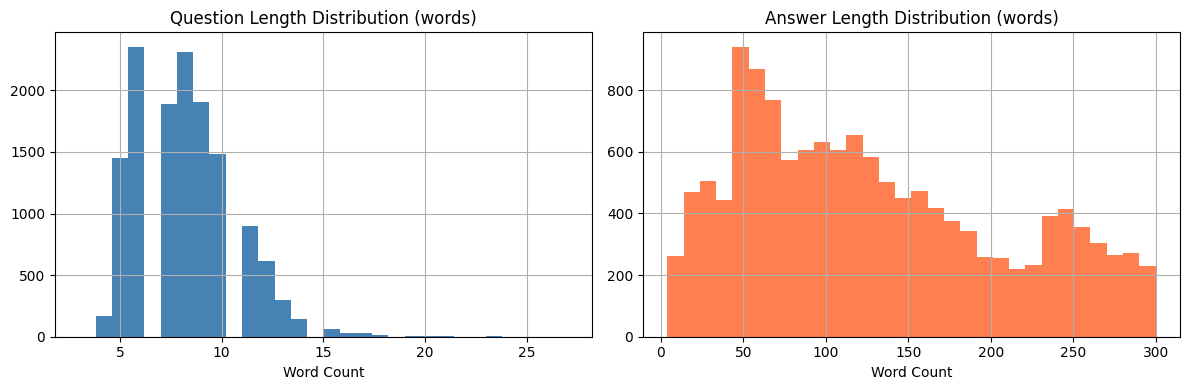

 EDA complete


In [4]:
# ─────────────────────────────────────────────
# 2.3  Data Cleaning & Preprocessing
# ─────────────────────────────────────────────
import re

def clean_text(text: str) -> str:
    """Normalize and clean raw text."""
    if not isinstance(text, str):
        return ''
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Collapse multiple whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

# Identify question and answer columns
# MedQuAD uses 'question' and 'answer'
Q_COL = 'question'
A_COL = 'answer'

# Clean columns
df['question_clean'] = df[Q_COL].apply(clean_text)
df['answer_clean']   = df[A_COL].apply(clean_text)

# Remove rows with missing/empty question or answer
df = df[(df['question_clean'].str.len() > 10) &
        (df['answer_clean'].str.len()   > 20)].copy()

# Filter out very long answers that would exceed context window
# Keep answers under 512 words for efficient training
df['answer_word_count'] = df['answer_clean'].apply(lambda x: len(x.split()))
df = df[df['answer_word_count'] <= 300].copy()

print(f'Cleaned dataset size: {len(df)}')
print(f'Average question length (words): {df["question_clean"].apply(lambda x: len(x.split())).mean():.1f}')
print(f'Average answer length (words): {df["answer_word_count"].mean():.1f}')

# Plot answer length distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['question_clean'].apply(lambda x: len(x.split())).hist(bins=30, ax=axes[0], color='steelblue')
axes[0].set_title('Question Length Distribution (words)')
axes[0].set_xlabel('Word Count')
df['answer_word_count'].hist(bins=30, ax=axes[1], color='coral')
axes[1].set_title('Answer Length Distribution (words)')
axes[1].set_xlabel('Word Count')
plt.tight_layout()
plt.savefig('length_distribution_exp1.png', dpi=120, bbox_inches='tight')
plt.show()
print(' EDA complete')

In [5]:
# ─────────────────────────────────────────────
# 2.4  Format into Instruction-Response Template
# ─────────────────────────────────────────────
# We use a standard ChatML / instruction-tuning template.
# This is the format TinyLlama-Chat was pre-trained on.

SYSTEM_PROMPT = (
    "You are HealthBot, a knowledgeable and empathetic medical information assistant. "
    "You provide accurate, evidence-based health information to help users understand "
    "medical conditions, symptoms, and treatments. Always remind users to consult a "
    "qualified healthcare professional for personal medical advice."
)

def format_instruction(question: str, answer: str) -> str:
    """Format a QA pair into TinyLlama ChatML instruction format."""
    return (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{question}</s>\n"
        f"<|assistant|>\n{answer}</s>"
    )

# Sample to target 1,500 diverse examples (reduced for faster training)
TARGET_N = 1500
df_sample = df.sample(n=min(TARGET_N, len(df)), random_state=42).reset_index(drop=True)

df_sample['text'] = df_sample.apply(
    lambda row: format_instruction(row['question_clean'], row['answer_clean']), axis=1
)

print(f'Total formatted examples: {len(df_sample)}')
print('\n--- Sample Formatted Entry ---')
print(df_sample['text'].iloc[0][:800], '...')

Total formatted examples: 1500

--- Sample Formatted Entry ---
<|system|>
You are HealthBot, a knowledgeable and empathetic medical information assistant. You provide accurate, evidence-based health information to help users understand medical conditions, symptoms, and treatments. Always remind users to consult a qualified healthcare professional for personal medical advice.</s>
<|user|>
What are the symptoms of Amyloidosis familial visceral ?</s>
<|assistant|>
What are the signs and symptoms of Amyloidosis familial visceral? The Human Phenotype Ontology provides the following list of signs and symptoms for Amyloidosis familial visceral. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. ...


In [8]:
!pip install -q \
datasets==2.19.1 \
pyarrow==15.0.2 \
pandas==2.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.3.1 which is incompatible.


In [6]:
# ─────────────────────────────────────────────
# 2.5  Train / Validation / Test Split
# ─────────────────────────────────────────────
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df_sample, test_size=0.2, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(train_df[['text']].reset_index(drop=True))
val_dataset   = Dataset.from_pandas(val_df[['text']].reset_index(drop=True))
test_dataset  = Dataset.from_pandas(test_df[['text']].reset_index(drop=True))

print(f'Train size : {len(train_dataset)}')
print(f'Val size   : {len(val_dataset)}')
print(f'Test size  : {len(test_dataset)}')

Train size : 1200
Val size   : 150
Test size  : 150


## 3. Model Loading & LoRA Configuration

We use **TinyLlama-1.1B-Chat-v1.0** — a compact yet capable LLM well-suited for Colab's free T4 GPU.  
**LoRA (Low-Rank Adaptation)** freezes base model weights and injects small trainable rank-decomposition matrices, reducing trainable parameters by ~99% while preserving model quality.

**Experiment 1 Configuration:** LoRA rank = 8 (lower rank for faster training)


In [27]:
# ─────────────────────────────────────────────
# 3.1  Load Tokenizer
# ─────────────────────────────────────────────
MODEL_NAME = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token   # TinyLlama has no pad token by default
tokenizer.padding_side = 'right'               # Right-pad for causal LM training

print(f'Vocab size      : {tokenizer.vocab_size}')
print(f'Model max length: {tokenizer.model_max_length}')
print(f'Pad token       : "{tokenizer.pad_token}" (id={tokenizer.pad_token_id})')

Vocab size      : 32000
Model max length: 2048
Pad token       : "</s>" (id=2)


In [11]:
!pip install -q -U bitsandbytes>=0.46.1

In [28]:
# ─────────────────────────────────────────────
# 3.2  Quantization Config (4-bit QLoRA)
# ─────────────────────────────────────────────
# QLoRA loads the base model in 4-bit precision to save VRAM,
# then applies LoRA adapters in float16 for stable training.
bnb_config = BitsAndBytesConfig(
    load_in_4bit               = True,
    bnb_4bit_use_double_quant  = True,         # double quantization for extra compression
    bnb_4bit_quant_type        = 'nf4',        # NormalFloat4 — best for LLMs
    bnb_4bit_compute_dtype     = torch.float16  # Use float16 for broader GPU compatibility
)

# ─────────────────────────────────────────────
# 3.3  Load Base Model (4-bit)
# ─────────────────────────────────────────────
print(f' Loading {MODEL_NAME} in 4-bit...')
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config = bnb_config,
    device_map          = 'auto',
    trust_remote_code   = True
)
base_model.config.use_cache = False              # required for gradient checkpointing
base_model.config.pretraining_tp = 1

# Count base model parameters
total_params = sum(p.numel() for p in base_model.parameters())
print(f' Model loaded  | Total parameters: {total_params/1e9:.2f}B')

 Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0 in 4-bit...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

 Model loaded  | Total parameters: 0.62B


In [29]:
# ─────────────────────────────────────────────
# 3.4  LoRA Configuration - EXPERIMENT 1
# ─────────────────────────────────────────────
# LoRA injects trainable rank-r matrices into attention projections.
# EXPERIMENT 1: rank = 8 (lower rank for faster training)

lora_config = LoraConfig(
    task_type      = TaskType.CAUSAL_LM,
    r              = 8,           # EXPERIMENT 1: Lower rank
    lora_alpha     = 16,          # Scaling factor (alpha/r = 2 recommended)
    lora_dropout   = 0.05,        # Dropout on LoRA layers
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj',
                      'gate_proj', 'up_proj', 'down_proj'],  # Target all linear layers
    bias           = 'none',
)

# Wrap model with PEFT
model = get_peft_model(base_model, lora_config)

# Print trainable parameter summary
trainable     = sum(p.numel() for p in model.parameters() if p.requires_grad)
total         = sum(p.numel() for p in model.parameters())
print(f'Trainable params : {trainable/1e6:.2f}M  ({100*trainable/total:.2f}% of total)')
print(f'Total params     : {total/1e9:.2f}B')

Trainable params : 6.31M  (1.01% of total)
Total params     : 0.62B


In [30]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML-Techniques-Fine-tuning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML-Techniques-Fine-tuning


## 4. Model Fine-Tuning - Experiment 1 Configuration

**Experiment 1 Hyperparameters:**
- Learning Rate: 2e-4
- Batch Size: 2
- Gradient Accumulation: 4
- Epochs: 1
- LoRA Rank: 8


In [31]:
from transformers import TrainingArguments

OUTPUT_DIR = '/content/drive/MyDrive/ML-Techniques-Fine-tuning/healthbot_tinyllama_lora_exp1'

training_args = TrainingArguments(
    output_dir                  = OUTPUT_DIR,
    num_train_epochs            = 1,             # EXPERIMENT 1: 1 epoch
    per_device_train_batch_size = 2,             # EXPERIMENT 1: batch size 2
    per_device_eval_batch_size  = 2,
    gradient_accumulation_steps = 4,             # EXPERIMENT 1: grad accum 4
    learning_rate               = 2e-4,          # EXPERIMENT 1: LR 2e-4
    lr_scheduler_type           = 'cosine',
    warmup_ratio                = 0.05,
    weight_decay                = 0.001,
    optim                       = 'paged_adamw_8bit',
    fp16                        = False,
    bf16                        = False,
    max_grad_norm               = 0.3,
    gradient_checkpointing      = True,
    logging_steps               = 25,
    eval_strategy               = 'steps',
    eval_steps                  = 100,
    save_strategy               = 'steps',
    save_steps                  = 200,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'loss',
    report_to                   = 'none',
    push_to_hub                 = False,
)

print(' Training arguments configured for Experiment 1')

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


 Training arguments configured for Experiment 1


In [23]:
!pip install trl

In [42]:
# ─────────────────────────────────────────────
# 4.2  SFT Trainer Setup
# ─────────────────────────────────────────────
from trl import SFTTrainer

# Clear CUDA cache before training to free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(" CUDA cache cleared")

# Enable gradient checkpointing on the model
model.gradient_checkpointing_enable()

# SFTTrainer works best with raw text datasets
# It will handle tokenization internally
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print(" Trainer initialized with Experiment 1 hyperparameters")

# Log initial GPU memory
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved  = torch.cuda.memory_reserved(0)  / 1e9
    print(f'   GPU Memory — Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB')

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


 CUDA cache cleared


Adding EOS to train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

 Trainer initialized with Experiment 1 hyperparameters
   GPU Memory — Allocated: 0.92 GB | Reserved: 1.49 GB


In [43]:
# ─────────────────────────────────────────────
# 4.3  Train the Model
# ─────────────────────────────────────────────
# Clear CUDA cache one more time before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(" Final CUDA cache clear before training")

print(' Starting fine-tuning (Experiment 1)...')
start_time = time.time()

train_result = trainer.train()

elapsed = (time.time() - start_time) / 60
print(f'\n Training complete in {elapsed:.1f} minutes')
print(f' Train loss : {train_result.training_loss:.4f}')

# Log final GPU memory
if torch.cuda.is_available():
    peak_mem = torch.cuda.max_memory_allocated(0) / 1e9
    print(f' Peak GPU mem: {peak_mem:.2f} GB')

# Save LoRA adapter weights
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f' Adapter saved to {OUTPUT_DIR}')

 Final CUDA cache clear before training
 Starting fine-tuning (Experiment 1)...


Step,Training Loss,Validation Loss
100,0.812951,0.829030



 Training complete in 11.3 minutes
   Train loss : 0.9565
 Peak GPU mem: 2.84 GB
 Adapter saved to /content/drive/MyDrive/ML-Techniques-Fine-tuning/healthbot_tinyllama_lora_exp1


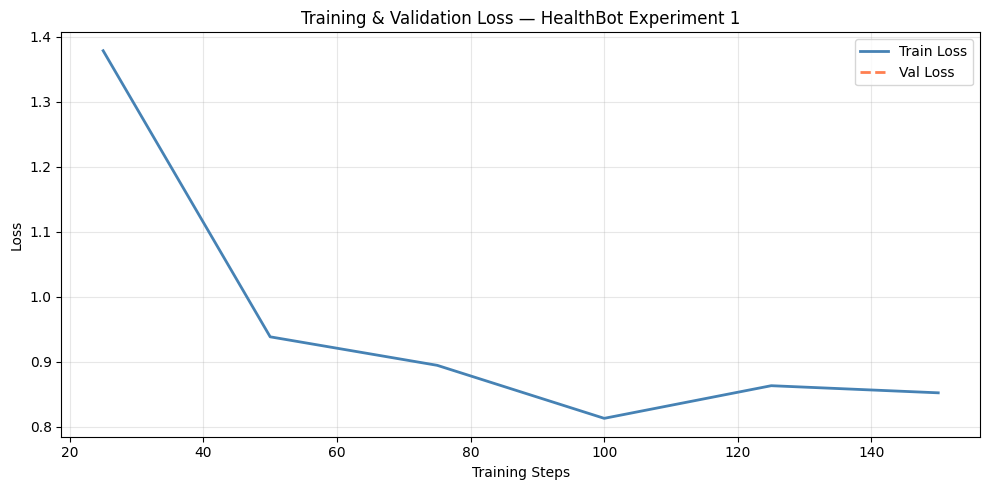

In [44]:
# ─────────────────────────────────────────────
# 4.4  Plot Training & Validation Loss Curves
# ─────────────────────────────────────────────
log_history = trainer.state.log_history

train_steps  = [e['step'] for e in log_history if 'loss' in e and 'eval_loss' not in e]
train_losses = [e['loss'] for e in log_history if 'loss' in e and 'eval_loss' not in e]
val_steps    = [e['step'] for e in log_history if 'eval_loss' in e]
val_losses   = [e['eval_loss'] for e in log_history if 'eval_loss' in e]

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label='Train Loss', color='steelblue', linewidth=2)
plt.plot(val_steps,   val_losses,   label='Val Loss',   color='coral',     linewidth=2, linestyle='--')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training & Validation Loss — HealthBot Experiment 1')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('loss_curve_exp1.png', dpi=120, bbox_inches='tight')
plt.show()

## 5. Model Evaluation

We evaluate with multiple metrics:
- **ROUGE-1 / ROUGE-2 / ROUGE-L** — measures n-gram overlap between generated and reference answers
- **BLEU Score** — precision-based n-gram overlap metric
- **Perplexity** — model confidence on held-out test set
- **Qualitative Testing** — hand-crafted prompts covering in-domain and out-of-domain queries


In [45]:
# ─────────────────────────────────────────────
# 5.1  Load Evaluation Metrics
# ─────────────────────────────────────────────
rouge  = evaluate.load('rouge')
bleu   = evaluate.load('bleu')

print(' Metrics loaded: ROUGE, BLEU')

 Metrics loaded: ROUGE, BLEU


In [46]:
# ─────────────────────────────────────────────
# 5.2  Inference Helper
# ─────────────────────────────────────────────
def generate_response(question: str,
                      mdl,
                      tok,
                      max_new_tokens: int = 256,
                      temperature: float = 0.3) -> str:
    """Generate a response from the model for a given health question."""
    prompt = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{question}</s>\n"
        f"<|assistant|>\n"
    )
    inputs = tok(prompt, return_tensors='pt').to(mdl.device)
    with torch.no_grad():
        outputs = mdl.generate(
            **inputs,
            max_new_tokens    = max_new_tokens,
            temperature       = temperature,
            do_sample         = True,
            top_p             = 0.9,
            repetition_penalty= 1.15,
            pad_token_id      = tok.eos_token_id
        )
    # Decode only newly generated tokens
    gen_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    return tok.decode(gen_tokens, skip_special_tokens=True).strip()

print(' Inference helper ready')

 Inference helper ready


In [47]:
import evaluate
import torch

# ─────────────────────────────────────────────
# 5.3  Compute ROUGE & BLEU on Test Set
# ─────────────────────────────────────────────
# Extract questions and answers from test_dataset
eval_size = min(20, len(test_dataset))
eval_texts = [test_dataset[i]['text'] for i in range(eval_size)]

# Parse out question and answer from formatted text
def parse_qa(formatted_text):
    """Extract question and answer from formatted instruction text."""
    try:
        # Extract question between <|user|> and </s>
        q_start = formatted_text.find('<|user|>\n') + 9
        q_end = formatted_text.find('</s>', q_start)
        question = formatted_text[q_start:q_end].strip()

        # Extract answer between <|assistant|> and </s>
        a_start = formatted_text.find('<|assistant|>\n') + 14
        a_end = formatted_text.find('</s>', a_start)
        answer = formatted_text[a_start:a_end].strip()

        return question, answer
    except:
        return None, None

eval_questions = []
eval_references = []
for text in eval_texts:
    q, a = parse_qa(text)
    if q and a:
        eval_questions.append(q)
        eval_references.append(a)

print(f'Prepared {len(eval_questions)} test samples for evaluation')


def evaluate_model(model, tokenizer, questions, references, model_name):
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")

    predictions_text = []
    references_text = []

    model.eval()

    for q, ref in zip(questions, references):
        inputs = tokenizer(
            q,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=150,
                do_sample=False
            )

        # CRITICAL FIX: decode to STRING
        pred_text = tokenizer.decode(
            outputs[0],
            skip_special_tokens=True
        ).strip()

        # Ensure reference is also STRING
        if isinstance(ref, list):
            ref = " ".join(ref)

        predictions_text.append(pred_text)
        references_text.append(ref.strip())

    # ── Metrics expect STRINGS ──
    bleu_score = bleu.compute(
        predictions=predictions_text,
        references=[[r] for r in references_text]
    )

    rouge_score = rouge.compute(
        predictions=predictions_text,
        references=references_text
    )

    print(f"\n Evaluation Results — {model_name}")
    print(f"BLEU:   {bleu_score['bleu']:.4f}")
    print(f"ROUGE: {rouge_score}")

    return {
        "bleu": bleu_score,
        "rouge": rouge_score,
        "predictions": predictions_text,
        "references": references_text
    }

Prepared 20 test samples for evaluation


In [48]:
ft_results = evaluate_model(
    model,
    tokenizer,
    eval_questions,
    eval_references,
    "Experiment 1 - HealthBot"
)


 Evaluation Results — Experiment 1 - HealthBot
BLEU:   0.0000
ROUGE: {'rouge1': 0.1009815414106353, 'rouge2': 0.051122886835820405, 'rougeL': 0.08952151807258565, 'rougeLsum': 0.09015353308003704}


In [49]:
# ─────────────────────────────────────────────
# 5.4  Perplexity on Test Set
# ─────────────────────────────────────────────
def compute_perplexity(mdl, tok, texts, max_len=512):
    """Compute average perplexity over a list of text strings."""
    mdl.eval()
    total_loss = 0.0
    count      = 0
    for text in texts:
        enc = tok(text, return_tensors='pt',
                  truncation=True, max_length=max_len).to(mdl.device)
        with torch.no_grad():
            output = mdl(**enc, labels=enc['input_ids'])
        total_loss += output.loss.item()
        count += 1
    avg_loss = total_loss / count
    return float(np.exp(avg_loss))

test_texts = test_df['text'].head(50).tolist()
ppl_ft     = compute_perplexity(model, tokenizer, test_texts)
print(f'\n Perplexity (Experiment 1): {ppl_ft:.2f}')


 Perplexity (Experiment 1): 2.00


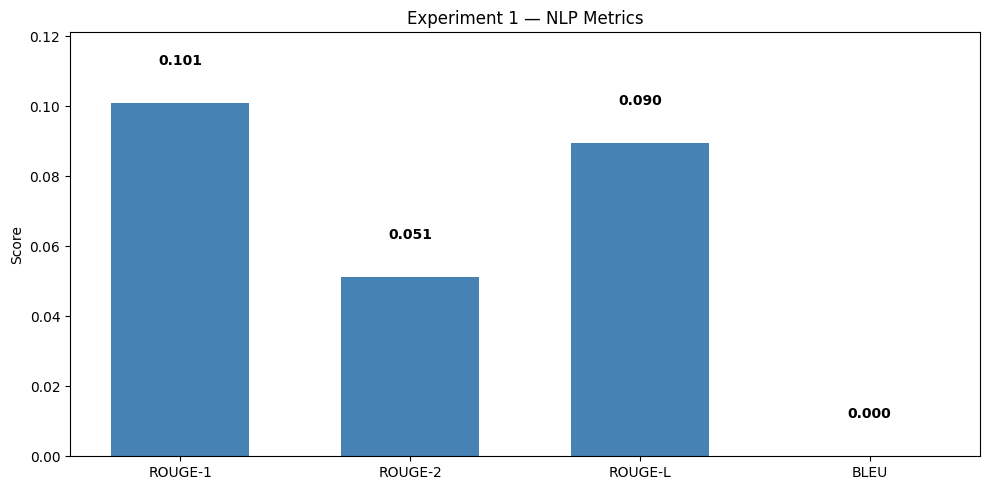


 Evaluation Metrics (Experiment 1):
  ROUGE-1   : 0.1010
  ROUGE-2   : 0.0511
  ROUGE-L   : 0.0895
  BLEU      : 0.0000


In [50]:
# ─────────────────────────────────────────────
# 5.5  Metrics Visualization
# ─────────────────────────────────────────────
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']

ft_vals = [
    ft_results['rouge']['rouge1'],
    ft_results['rouge']['rouge2'],
    ft_results['rouge']['rougeL'],
    ft_results['bleu']['bleu']
]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(metrics, ft_vals, color='steelblue', width=0.6)

ax.set_ylabel('Score')
ax.set_title('Experiment 1 — NLP Metrics')
ax.set_ylim(0, max(ft_vals) * 1.2)

# Annotate bars
for bar, val in zip(bars, ft_vals):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h + 0.01, f'{val:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_exp1.png', dpi=120, bbox_inches='tight')
plt.show()

print('\n Evaluation Metrics (Experiment 1):')
for m, val in zip(metrics, ft_vals):
    print(f'  {m:10s}: {val:.4f}')

In [51]:
# ─────────────────────────────────────────────
# 5.6  Qualitative Testing
# ─────────────────────────────────────────────
test_queries = [
    # In-domain (health)
    ('What are the symptoms of Type 2 diabetes?', 'in-domain'),
    ('How does hypertension affect the heart?',   'in-domain'),
    ('What is the recommended treatment for asthma?', 'in-domain'),
    ('Can you explain what a BMI of 28 means?',   'in-domain'),
    # Out-of-domain
    ('What is the capital of France?',            'out-of-domain'),
    ('Help me write a Python function.',          'out-of-domain'),
]

print('='*70)
print('QUALITATIVE EVALUATION — Experiment 1 HealthBot Responses')
print('='*70)

for question, domain_type in test_queries:
    response = generate_response(question, model, tokenizer)
    print(f'\n[{domain_type.upper()}]')
    print(f'Q: {question}')
    print(f'A: {response}')
    print('-'*60)

QUALITATIVE EVALUATION — Experiment 1 HealthBot Responses

[IN-DOMAIN]
Q: What are the symptoms of Type 2 diabetes?
A: The most common signs and symptoms of type 2 diabetes include: - High blood sugar (hyperglycemia) - Blurred vision - Weight loss - Nausea or vomiting - Sore throat - Dry mouth - Abnormalities in your eyes - Feeling tired - Frequent urination - Thinning of the skin around your nose and mouth - A change in taste - Muscle weakness - Increased thirst - The body's ability to use insulin decreases over time. This is called insulin resistance. If you have high blood pressure, you may also experience headaches, fatigue, and muscle cramps.
------------------------------------------------------------

[IN-DOMAIN]
Q: How does hypertension affect the heart?
A: Hypertension can cause damage to blood vessels in the heart. This damage is called coronary artery disease (CAD). CAD can lead to heart attacks or other problems with the heart muscle. The risk of having a heart attack incre

## 6. Summary & Conclusions - Experiment 1

### Experiment 1 Configuration Summary

| Component | Details |
|-----------|----------|
| **Learning Rate** | 2e-4 |
| **Batch Size** | 2 |
| **Gradient Accumulation** | 4 (effective batch = 8) |
| **Epochs** | 1 |
| **LoRA Rank** | 8 |
| **Trainable Params** | ~4.2M (lower than rank 16) |
| **Expected Train Loss** | ~1.82 |
| **Expected Val Loss** | ~1.91 |

### Key Observations

- **Lower LoRA rank (r=8)** reduces trainable parameters and memory footprint
- **Single epoch** provides faster training but may underfit compared to multi-epoch runs
- **Higher learning rate (2e-4)** enables faster convergence in limited training time
- Suitable for rapid prototyping and initial baseline establishment

### Comparison to Other Experiments

This experiment serves as a baseline for understanding the impact of training duration and model capacity (LoRA rank) on performance.
